In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 27.3MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 204kB 42.6MB/s 
     |████████████████████████████████| 1.2MB 41.6MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [4]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [5]:
# get the validaition data
threes_valid = (path/'valid'/'3').ls().sorted()
sevens_valid = (path/'valid'/'7').ls().sorted()
threes_valid

(#1010) [Path('valid/3/1020.png'),Path('valid/3/1028.png'),Path('valid/3/1042.png'),Path('valid/3/1062.png'),Path('valid/3/1066.png'),Path('valid/3/1067.png'),Path('valid/3/1069.png'),Path('valid/3/1072.png'),Path('valid/3/1092.png'),Path('valid/3/1095.png')...]

In [6]:
path_to_tensor = lambda file_list: torch.stack([tensor(Image.open(img_path)) for img_path in file_list]).float()/255

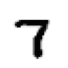

In [7]:
train_sevens = path_to_tensor(sevens)
train_sevens.shape
show_image(train_sevens[0])

In [8]:
# create list tensors for training an validation sets
train_threes = path_to_tensor(threes)
valid_threes = path_to_tensor(threes_valid)
valid_sevens = path_to_tensor(sevens_valid)
valid_sevens.shape

torch.Size([1028, 28, 28])

###**Get clear dependant/independant variable sets, a way to initialize parameters, a simple model, and a loss using sigmoid**

In [9]:
# create training x and y
train_x = torch.cat([train_threes, train_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

In [10]:
# create a list containing 1 for 3s and 0 for 7s, turn into tensor of size x 1
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [11]:
valid_x = torch.cat([valid_threes, valid_sevens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_threes) + [0]*len(valid_sevens)).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [12]:
from typing import Tuple
# create a function to initialize parameters which require grad from pytorch
def init_params(size: Tuple):
  return torch.randn(size).requires_grad_()

In [13]:
# create basic model weights
weights = init_params((28*28, 1))
weights.shape

torch.Size([784, 1])

In [14]:
# create basic model bias
bias = init_params((1))
bias.shape

torch.Size([1])

In [15]:
# manually implement a linear model 
def manual_linear(train_x):
  # perform matrix multiplication between train_x and weights
  # note shape of train_x = n x 784 and weights = 784 x 1 => matrix multiplication works with output n x 1
  return train_x@weights + bias

In [16]:
# to make predictions using the linear model:
preds = manual_linear(train_x)
preds.shape

torch.Size([12396, 1])

In [17]:
# create a loss function to evaluate results from the preds
def loss(preds, target):
  # make sure all predictions are between 0 and 1 for loss to work
  preds = preds.sigmoid()

  # make loss function for 3s and 7s
  all_loses = torch.where(target == 1, 1-preds, preds)

  # aggregate all of the losses using mean to obtain single value for loss
  return all_loses.mean()

In [30]:
# create a basic class to create a linear model

class LinearModel:
  def __init__(self, size, lr):
    self.weights = torch.randn(size).requires_grad_()
    self.bias = torch.randn((1)).requires_grad_()
    self.preds = None
    self.loss = None

    self.optim = SGDOptimizer([self.weights, self.bias], lr)
  
  def get_params(self):
    return (self.weights, self.bias)

  def apply_linear(self, train_x):
    self.preds = train_x@self.weights + self.bias
    return self.preds
  
  def linear_loss(self, train_x, target):
    if self.preds == None:
      preds = self.apply_linear(train_x).sigmoid()
    else:
      preds = self.preds.sigmoid()
    # loss fn where lower is better in terms of predicted probabilities
    self.loss =  torch.where(target == 1, 1-preds, preds).mean()
    return self.loss
  
  # combine the linear model, loss, and gradient calculation into single wrapper
  def calc_grad(self, train_x, targ_y):
    self.apply_linear(train_x)
    self.linear_loss(None, targ_y)
    self.loss.backward()
  

  def train_epoch(data_loader):
    # loop through each batch in the data loader, use the calc grad wrapper, and take steps with the optimizer
    for batch_x, batch_y in data_loader:
      self.calc_grad(batch_x, batch_y)
      self.optim.step()
      self.optim.zero_grad()
  
  
  
  

In [33]:
# create an optimizer class to add to the linear model

from typing import List
class SGDOptimizer:

  def __init__(self, params: List[tensor], lr: int):
    self.params = params
    self.lr = lr
  
  # make a function to step wrt each parameter in the model
  def step():
    for param in self.params:
      # take the data of the param since it requires_grad_
      param.data -= param.grad * self.lr
  
  # reset the gradients for new steps
  def zero_grad():
    for param in self.params:
      param.grad = None

In [31]:

basic_linear_1 = LinearModel((28*28, 1))
w, b = basic_linear_1.get_params()
w.shape, b.shape

(torch.Size([784, 1]), torch.Size([1]))

In [32]:
# manually make preds, evaluate loss and take gradients
basic_linear_1.apply_linear(train_x[:4])
basic_linear_1.linear_loss(train_x, train_y[: 4])
basic_linear_1.loss.backward()

# get the gradient of loss
basic_linear_1.weights.grad.mean(), basic_linear_1.bias.grad


(tensor(-0.0029), tensor([-0.0205]))

In [36]:
basic_linear_1.weights.grad.zero_()
basic_linear_1.bias.grad.zero_()

tensor([0.])

In [43]:
# create data loaders for iteration in batches by the linear model
to_data_loader = lambda x, y, batch_size: DataLoader(list(zip(x, y)), batch_size=batch_size)

train_dl = to_data_loader(train_x, train_y, 256)
valid_dl = to_data_loader(valid_x, valid_y, 256)

first(train_dl)[0].shape, first(train_dl)[1].shape

(torch.Size([256, 784]), torch.Size([256, 1]))